In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import process_data.dire_and_coor as dc
import functions as func
import process_data.n_n_distance as nn
import json

## 27 Oct
1. random walk training for single node
2. 14 in, 14 out
3. the input noise is normal distribution
4. the expected output of generator is 4 peaks: 0, 1/4, 1/2, 3/4
5. lr = 0.001, generator(sigmoid, sigmoid), discriminator(leaky relu, sigmoid)
6. adam is using

In [2]:
# load the model
import fnn.single_node as single_node
generator = single_node.GeneratorNet(14, 14)

In [48]:
with open('../experiments/11_3/batch_size_128/four_layers_gen.json', 'r') as fp:
    data = json.load(fp)
with open('../experiments/11_3/batch_size_128/four_layers_disc.json', 'r') as fp:
    data_1 = json.load(fp)

In [49]:
c = []
d = []
for i in data:
    c += data[i]
    d += data_1[i]

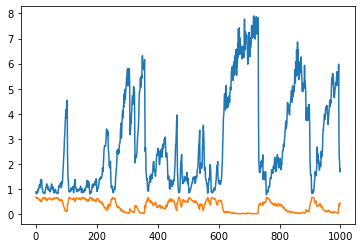

In [50]:
plt.plot(c)
plt.plot(d)

In [3]:
def check_output_hist(gen, number_bin, z_dim, num_polymer, epoch):

    noise = func.get_noise(num_polymer, z_dim)
    output = gen(noise).data.numpy()
    output = output.reshape(-1,1)

    plt.hist(output, density=True, bins=number_bin)
    plt.title(f'output of generator{epoch}')
    plt.show()

    # output = np.round(output * 4) / 4
    # sns.histplot(output)
    # plt.title('output of generator after round')
    # plt.show()


def round_and_reshape(model, num_polymer, z_dim, shifted=True):
    # load model
    # get output
    noise = func.get_noise(num_polymer, z_dim)
    output = model(noise).data.numpy()
    # round and reshape output
    output = np.round(output * 4) / 4
    if shifted:
        output += (0.75/2)
    for i in range(len(output)):
        for j in range(len(output[i])):
            if output[i][j] == 1.:
                output[i][j] = 0
    directions_14 = output.reshape((num_polymer, 14, 1))
    directions = np.zeros((num_polymer, 15, 1))
    for i in range(len(directions)):
        directions[i] = np.vstack(([0], directions_14[i]))
    return directions


# noise = func.get_noise(100000, 14)
# output = generator(noise).data.numpy()
# for par in generator.parameters():
#     print(par)

NameError: name 'generator' is not defined

## conclusion we can draw for now
1. the single node won't work for GAN, single node means no hidden layers, no matter how many

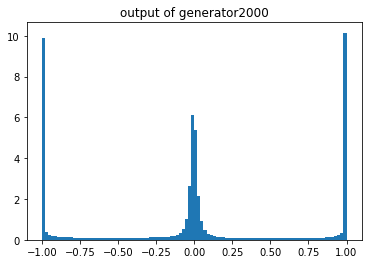

In [4]:
import fnn.four_layers as four_layers
generator = four_layers.GeneratorNet(14, 28)
# for i in range(1, 19):
check_point = torch.load(f'../experiments/11_5/four_layers_sin_cos_gen_{2000}.pth.tar')
generator.load_state_dict(check_point['gen_state_dict'])
check_output_hist(generator, 100, 14, 100000, 2000)

In [5]:
num_polymer = 10000
z_dim = 14
noise = func.get_noise(num_polymer, z_dim)
output = generator(noise).data.numpy()

output = output.reshape(num_polymer, 14, 2)
# convert sin cos coordinates to turn directions
directions = np.zeros([num_polymer, 14, 1])
convert = {
    "backward": 0,
    "right_turn": 1/4,
    "forward": 1 / 2,
    "left_turn": 3 / 4
}

for index, direction in enumerate(directions):
# test = np.zeros((14, 1))
#     j = 0
    for j, item in enumerate(output[index]):
        if item[np.argmax(np.abs(item))] < 0:
            if np.argmax(np.abs(item)) == 0:
                # the result is [-1,0]
                direction[j] = convert['backward']
            else:
                # result is [0,-1]
                direction[j] = convert['left_turn']
        elif item[np.argmax(np.abs(item))] > 0:
            if np.argmax(np.abs(item)) == 0:
                # the result is [1,0]
                direction[j] = convert['forward']
            else:
                # result is [0,1]
                direction[j] = convert['right_turn']

In [6]:
a = np.zeros((10000, 15, 1))
# make the first one is forward
for i in range(len(a)):
    a[i] = np.vstack(([0], directions[i]))
coordinates = dc.direction_coordinate_three(a, 16)

In [7]:
nn.n_n_distance(coordinates)

3.8045236232674386

In [8]:
3.79 * 3.79 / 15

0.9576066666666667

In [12]:
def direction_to_str(directions):
    st_all = []
    for direction in directions:
        st = ""
        for i in direction:
            st += str(int(i[0] * 4))
        st_all.append(st)
    return st_all

In [13]:
c = direction_to_str(directions)

In [14]:
list_2 = list(set(c))

In [15]:
len(list_2)


9092